In [3]:
!io/io-static -c iofile

Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: create
  path: iofile
  time: 2.055441251
7971.04 KBytes/sec


In [8]:
flags = "-r"
!io/io-static {str(flags)} /dev/zero

16267.66 KBytes/sec


In [22]:
# test with small buffer
flags = "-r"
!io/io-static {str(flags)} -B  -b 4096 -t {str(16*1024*1024)} iofile

42778.10 KBytes/sec


In [21]:
# test with high buffer
flags = "-r"
!io/io-static {str(flags)} -B  -b 32768 -t {str(16*1024*1024)} iofile

116506.37 KBytes/sec


In [2]:
!io/io-static -v -w iofile


Benchmark configuration:
  buffersize: 16384
  totalsize: 16777216
  blockcount: 1024
  operation: write
  path: iofile
  time: 2.067294916
7925.33 KBytes/sec


In [3]:
!/usr/bin/time -p io/io-static -r -B -d -q iofile

real 1.29
user 0.00
sys 0.31


In [1]:
!io/io-static -c iofile

/bin/sh: io/io-static: not found


In [3]:
# IO performance varying the buffer size
io_performance_script = """

BEGIN {
}

syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
    self->cstart = vtimestamp;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
    trace(vtimestamp - self->cstart);
}

END
{
    exit(0);
}
"""

from collections import defaultdict
walk_dict = defaultdict(int)

values = []
from collections import defaultdict
aggr_dict = defaultdict(int)


# Callback invoked to print the trace record
# (that is, printf("%u", vtimestamp - self->start))


def benchmark(flags, output_name, trials, buff_sizes, file_name, dtrace_script,quiet=False):
    values = []
    aggr_dict = defaultdict(int)
    
    def simple_out(value):
        values.append(value)
    
    def walk_func(a, b, c, d):
        aggr_dict[c[0]] += d
    
   # print_header(["Starting io-static performance measurement",flags])

        # Create a seperate thread to run the DTrace instrumentation
    dtrace_thread = DTraceConsumerThread(dtrace_script,
                                        chew_func=lambda v: None,
                                        chewrec_func=lambda v: None,
                                        out_func=simple_out,
                                        walk_func=walk_func,
                                        sleep=1)

    # Start the DTrace instrumentation
    dtrace_thread.start()

    # Display header to indicate that the benchmarking has started
    for size in buff_sizes:
        if not quiet:
            print("buffer size:", size, "collected so far: ",len(values))
        for i in range(trials):
            output = !io/io-static {flags} -B -q -b {str(size)} -t {str(TOTAL_SIZE)} {file_name}
            
    # The benchmark has completed - stop the DTrace instrumentation
    dtrace_thread.stop()
    dtrace_thread.join()
    dtrace_thread.consumer.__del__()

    if not quiet:
        print("values collected:", len(values))

    with open("lab1_{}_0702.data".format(output_name), 'w') as f:
        f.write(",".join([str(s) for s in BUFFER_SIZES]))
        f.write("\n")
        for value in values:
            f.write(value)
            f.write("\n")
    return values, aggr_dict

In [4]:
# Run the io-static benchmark    
TOTAL_SIZE = 16*1024*1024
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]
NUM_TRIALS = 10

In [39]:
benchmark("-r", "read",NUM_TRIALS,BUFFER_SIZES, "iofile",io_performance_script)
print_footer(["Finished io-static read performance measurement"])

('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 17)
('buffer size:', 4096, 'collected so far: ', 31)
('buffer size:', 8192, 'collected so far: ', 56)
('buffer size:', 16384, 'collected so far: ', 75)
('buffer size:', 32768, 'collected so far: ', 94)
('buffer size:', 65536, 'collected so far: ', 113)
('buffer size:', 131072, 'collected so far: ', 133)
('buffer size:', 262144, 'collected so far: ', 152)
('buffer size:', 524288, 'collected so far: ', 171)
('buffer size:', 1048576, 'collected so far: ', 190)
('buffer size:', 2097152, 'collected so far: ', 209)
('buffer size:', 4194304, 'collected so far: ', 237)
('buffer size:', 8388608, 'collected so far: ', 256)
('buffer size:', 16777216, 'collected so far: ', 273)
('values collected:', 299)
********************************************************************************
* Finished io-static read performance measurement
**************************************************************************

In [14]:
benchmark("-w", "write",NUM_TRIALS,BUFFER_SIZES, "iofile",io_performance_script)
print_footer(["Finished io-static write performance measurement"])

********************************************************************************
* Starting io-static performance measurement
* -w
********************************************************************************
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 18)
('buffer size:', 4096, 'collected so far: ', 38)
('buffer size:', 8192, 'collected so far: ', 58)
('buffer size:', 16384, 'collected so far: ', 78)
('buffer size:', 32768, 'collected so far: ', 98)
('buffer size:', 65536, 'collected so far: ', 118)
('buffer size:', 131072, 'collected so far: ', 138)
('buffer size:', 262144, 'collected so far: ', 158)
('buffer size:', 524288, 'collected so far: ', 178)
('buffer size:', 1048576, 'collected so far: ', 198)
('buffer size:', 2097152, 'collected so far: ', 218)
('buffer size:', 4194304, 'collected so far: ', 238)
('buffer size:', 8388608, 'collected so far: ', 258)
('buffer size:', 16777216, 'collected so far: ', 278)
('values collected:'

In [45]:
benchmark("-w -s", "write_sync",NUM_TRIALS,BUFFER_SIZES, "iofile",io_performance_script)
print_footer(["Finished io-static write performance measurement"])

('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 18)
('buffer size:', 4096, 'collected so far: ', 38)
('buffer size:', 8192, 'collected so far: ', 58)
('buffer size:', 16384, 'collected so far: ', 78)
('buffer size:', 32768, 'collected so far: ', 98)
('buffer size:', 65536, 'collected so far: ', 118)
('buffer size:', 131072, 'collected so far: ', 138)
('buffer size:', 262144, 'collected so far: ', 158)
('buffer size:', 524288, 'collected so far: ', 178)
('buffer size:', 1048576, 'collected so far: ', 198)
('buffer size:', 2097152, 'collected so far: ', 218)
('buffer size:', 4194304, 'collected so far: ', 238)
('buffer size:', 8388608, 'collected so far: ', 258)
('buffer size:', 16777216, 'collected so far: ', 278)
('values collected:', 299)
********************************************************************************
* Finished io-static write performance measurement
*************************************************************************

In [20]:
benchmark("-r", "read_zero",NUM_TRIALS,BUFFER_SIZES, "/dev/zero",io_performance_script)


********************************************************************************
* Starting io-static performance measurement
* -r
********************************************************************************
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 11)
('buffer size:', 4096, 'collected so far: ', 24)
('buffer size:', 8192, 'collected so far: ', 53)
('buffer size:', 16384, 'collected so far: ', 69)
('buffer size:', 32768, 'collected so far: ', 83)
('buffer size:', 65536, 'collected so far: ', 113)
('buffer size:', 131072, 'collected so far: ', 129)
('buffer size:', 262144, 'collected so far: ', 143)
('buffer size:', 524288, 'collected so far: ', 173)
('buffer size:', 1048576, 'collected so far: ', 186)
('buffer size:', 2097152, 'collected so far: ', 212)
('buffer size:', 4194304, 'collected so far: ', 237)
('buffer size:', 8388608, 'collected so far: ', 249)
('buffer size:', 16777216, 'collected so far: ', 273)
('values collected:'

In [21]:
benchmark("-w", "write_zero",NUM_TRIALS,BUFFER_SIZES, "/dev/zero",io_performance_script)


********************************************************************************
* Starting io-static performance measurement
* -w
********************************************************************************
('buffer size:', 1024, 'collected so far: ', 0)
('buffer size:', 2048, 'collected so far: ', 15)
('buffer size:', 4096, 'collected so far: ', 31)
('buffer size:', 8192, 'collected so far: ', 48)
('buffer size:', 16384, 'collected so far: ', 65)
('buffer size:', 32768, 'collected so far: ', 83)
('buffer size:', 65536, 'collected so far: ', 117)
('buffer size:', 131072, 'collected so far: ', 135)
('buffer size:', 262144, 'collected so far: ', 153)
('buffer size:', 524288, 'collected so far: ', 171)
('buffer size:', 1048576, 'collected so far: ', 189)
('buffer size:', 2097152, 'collected so far: ', 207)
('buffer size:', 4194304, 'collected so far: ', 225)
('buffer size:', 8388608, 'collected so far: ', 243)
('buffer size:', 16777216, 'collected so far: ', 259)
('values collected:'

In [127]:
%matplotlib inline

def plot_graph(input_data_file, title, secondary = [],save = True):
    # Plot the read performance (IO bandwidth against buffer size with error bars)
    with open(input_data_file, 'r') as f:
        content = f.readlines()

    # Buffer sizes to compute the performance with
    BUFFER_SIZES = [int(v) for v in content[0].split(',')]

    # Total size of iofile (default size) = 16MiB
    TOTAL_SIZE = BUFFER_SIZES[-1] #16*1024*1024
    read_performance_values =  [int(v.strip()) for v in content[1::2]]

    # Number of trials for each buffer size
    NUM_TRIALS = 10

    # Compute the IO bandwidth in KiBytes/sec
    io_bandwidth_values = [(TOTAL_SIZE/1024)/(val/1e9) for val in read_performance_values]
    io_bandwidth_avg = [sum(io_bandwidth_values[i*NUM_TRIALS:(i+1)*NUM_TRIALS])/NUM_TRIALS for i in range(len(BUFFER_SIZES))]

    # Reshape the list into an array of size [len(BUFFER_SIZES), NUM_TRIALS]
    io_bandwidth = np.reshape(io_bandwidth_values, (len(BUFFER_SIZES), NUM_TRIALS))[:,:]

    # Convert the array of io bandwidth values into a Panda DataFrame
    # this allows ploting of the median value and computation of the 
    # error bars (25 and 75 percentile values)
    # Note: The error bars should be small indicating that the experiment is tightly controlled
    df = pd.DataFrame(io_bandwidth, index=BUFFER_SIZES)
   

    # Compute error bars based on the 25 and 75 quartile values
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]

    # Create and label the plot

    plt.figure();
    ax = df.median(1).plot(figsize=(9,9), yerr=error_bars_values)#, label="io-static {}".format(label))


    
    plt.title(title)#'io-static {} performance'.format(label))
    plt.ylabel('I/O bandwidth (KiBytes/sec)')
    plt.xlabel('Buffer size (Bytes)')
    plt.xscale('log')

    # Plot a vertical line at 1MiB
    #plt.axvline(x=1024*1024, color='g')
    max_perf = np.argmax(np.array(io_bandwidth_avg))
    plt.axvline(x=BUFFER_SIZES[max_perf], color='r')
    print(max_perf,BUFFER_SIZES[max_perf])

    if save:
        plt.savefig("io_performance_{}.png".format(title.replace("/","").replace(" ","_")))
        
    return ax

(5, 32768)


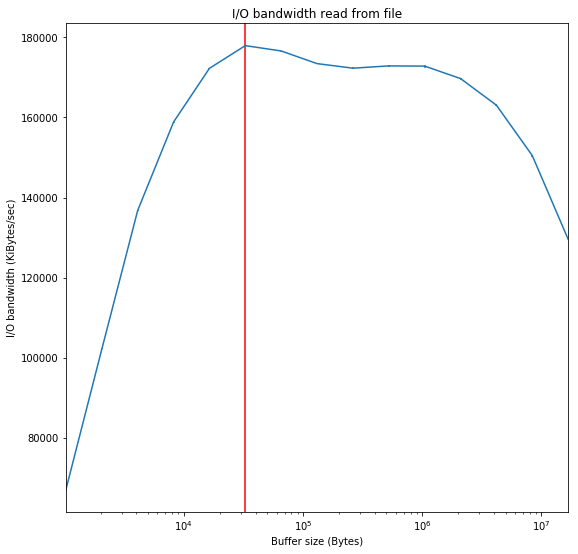

In [8]:
plot_graph("lab1_read_0702.data", "I/O bandwidth read from file")


(4, 16384)


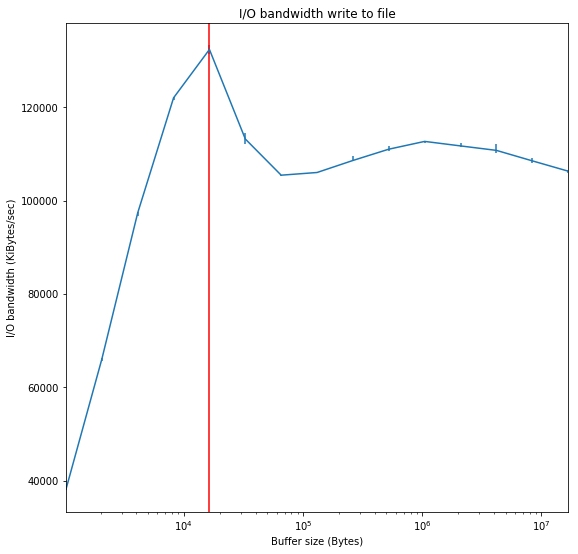

In [43]:
plot_graph("lab1_write_0702.data", "I/O bandwidth write to file")

(4, 16384)


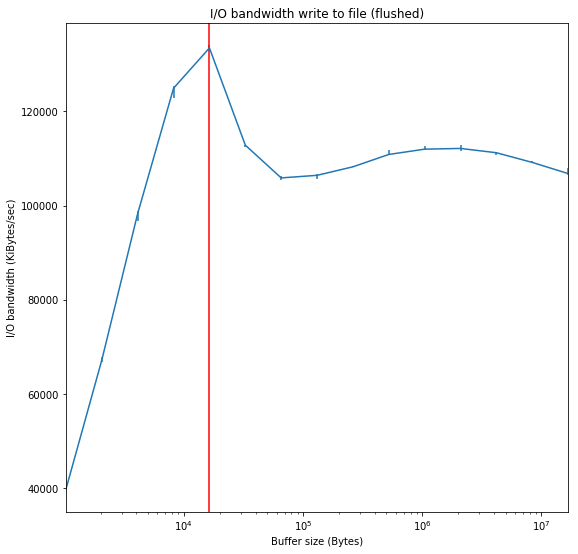

In [46]:
plot_graph("lab1_write_sync_0702.data", "I/O bandwidth write to file (flushed)")

(6, 65536)


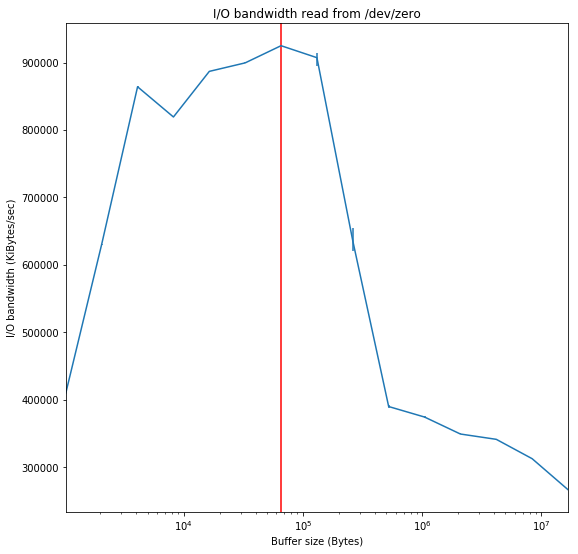

In [10]:
plot_graph("lab1_read_zero_0702.data", "I/O bandwidth read from /dev/zero")


(14, 16777216)


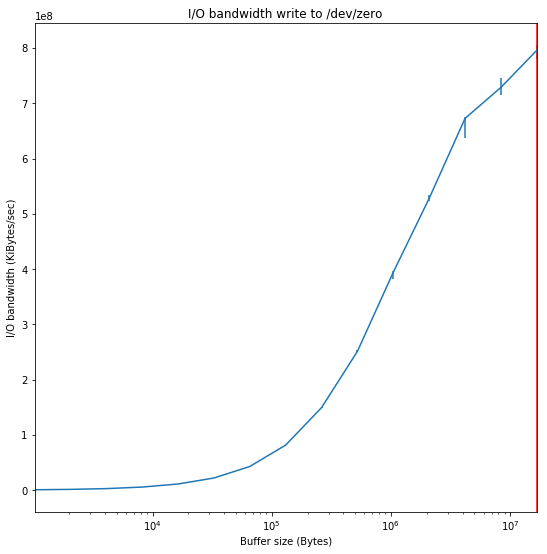

In [11]:
plot_graph("lab1_write_zero_0702.data", "I/O bandwidth write to /dev/zero")


In [23]:
# probe effect
io_performance_script_wno_probes = """

BEGIN {
}

syscall::execve:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
    self->star_time = vtimestamp;
}

syscall::exit:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
    printf("tot %d",timestamp - self->star_time); 
}

"""

io_performance_script_w_probes = io_performance_script_wno_probes + """

syscall::clock_gettime:return
/execname == "io-static" && !self->timing/
{
    self->timing = 1;
    self->clock_start = vtimestamp;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->timing/
{
    self->timing = 0;
    printf("io %d",vtimestamp - self->clock_start);
}

"""

BUFFER_SIZES = [1024 * 2 ** exp for exp in range(5, 6)]
TOTAL_SIZE = 16*1024*1024

def measure_single_probe_overhead(buffer_size, iofile="/dev/zero"):
    wno_probes = benchmark("-r", "read_wno_probes",1,[buffer_size], iofile,io_performance_script_wno_probes,quiet=True)
    w_probes = benchmark("-r", "read_w_probes",1,[buffer_size],iofile,io_performance_script_w_probes,quiet=True)

    print("With probes:")
    print(w_probes)
    tot_time_with_probes = int(w_probes[1].split(" ")[1])

    print("Without probes:")
    print(wno_probes)
    tot_time_wno_probes = int(wno_probes[0].split(" ")[1])

    probe_overhead = (tot_time_with_probes - tot_time_wno_probes)
    return probe_overhead

def measure_probe_overhead(buffer_size,trials, iofile="iofile"):
    avg_probe_overhead = sum(
        [measure_single_probe_overhead(buffer_size,iofile) for i in range(trials)]
    ) / trials
    
    print("Probe effect: {} ms".format(avg_probe_overhead/1e6))

    return avg_probe_overhead

for buffer_s in BUFFER_SIZES:
    print("Buffer size: {}".format(buffer_s))
    print(measure_probe_overhead(buffer_s, 3))

print_footer(["Finished probe effect comaprison."])

Buffer size: 32768
With probes:
['io 92412308', 'tot 9041610760609']
Without probes:
['tot 9040496513161']
With probes:
['io 92001637', 'tot 9044216925854']
Without probes:
['tot 9042952357336']
With probes:
['io 92254327', 'tot 9046517755616']
Without probes:
['tot 9045385123061']
Probe effect: 1170.48284 ms
1170482840
********************************************************************************
* Finished probe effect comaprison. Overhead: 1263.839859ms
********************************************************************************


In [1]:
import pprint
BUFFER_SIZES = [1024 * 2 ** exp for exp in range(0, 15)]


In [5]:
# trace while io
complete_trace = """

BEGIN {
}

syscall::clock_gettime:return
/execname == "io-static" && !self->in_benchmark/
{
    self->in_benchmark = 1;
    self->cstart = vtimestamp;
}

syscall::clock_gettime:entry
/execname == "io-static" && self->in_benchmark/
{
    self->in_benchmark = 0;
}

syscall::execve:return
/execname == "io-static" && !self->in_benchmark/
{
    /* self->in_benchmark = 1; */
    self->star_time = vtimestamp;
}

fbt::vn_read:,
fbt::vn_io_fault:,
fbt::vn_io_fault_doio:
/self->in_benchmark/ 
{
        @a[probefunc] = count();
}


syscall::exit:entry
/execname == "io-static"/
{
    printf("tot %d",timestamp - self->star_time); 
    printa(@a);
}




"""
import json
def pp(dic):
    print json.dumps(dic, indent=1)

    
from collections import defaultdict
to_plot = defaultdict(list)
import pprint
for size in BUFFER_SIZES:
    res = benchmark("-r", "vpage_fault",1,[size], "iofile",complete_trace,True)
   # time = int(res[0])
    values = res[1]
    for key, value in values.items():
        to_plot[key].append(value)
        
    pp(benchmark("-r", "vpage_fault",1,[size], "iofile",complete_trace,True)[1])

pp(to_plot)


{
 "vn_read": 32768, 
 "vn_io_fault": 65536, 
 "vn_io_fault_doio": 32768
}
{
 "vn_read": 16384, 
 "vn_io_fault": 32768, 
 "vn_io_fault_doio": 16384
}
{
 "vn_read": 8192, 
 "vn_io_fault": 16384, 
 "vn_io_fault_doio": 8192
}
{
 "vn_read": 4096, 
 "vn_io_fault": 8192, 
 "vn_io_fault_doio": 4096
}
{
 "vn_read": 2050, 
 "vn_io_fault": 4096, 
 "vn_io_fault_doio": 2050
}
{
 "vn_read": 1026, 
 "vn_io_fault": 2048, 
 "vn_io_fault_doio": 1026
}
{
 "vn_read": 514, 
 "vn_io_fault": 1024, 
 "vn_io_fault_doio": 514
}
{
 "vn_read": 260, 
 "vn_io_fault": 512, 
 "vn_io_fault_doio": 260
}
{
 "vn_read": 136, 
 "vn_io_fault": 256, 
 "vn_io_fault_doio": 136
}
{
 "vn_read": 80, 
 "vn_io_fault": 128, 
 "vn_io_fault_doio": 80
}
{
 "vn_read": 64, 
 "vn_io_fault": 64, 
 "vn_io_fault_doio": 64
}
{
 "vn_read": 80, 
 "vn_io_fault": 32, 
 "vn_io_fault_doio": 80
}
{
 "vn_read": 136, 
 "vn_io_fault": 16, 
 "vn_io_fault_doio": 136
}
{
 "vn_read": 260, 
 "vn_io_fault": 8, 
 "vn_io_fault_doio": 260
}
{
 "vn_read": 514, 

Axes(0.125,0.125;0.775x0.755)


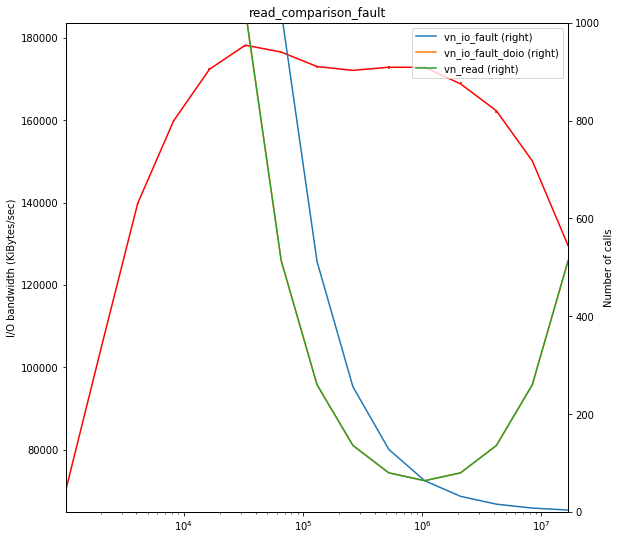

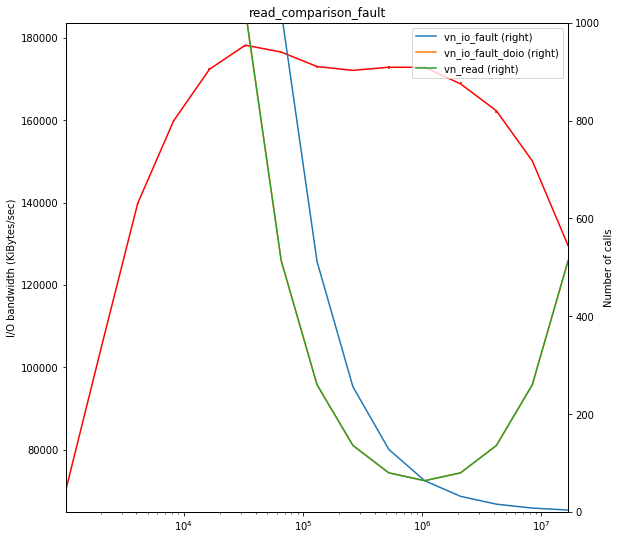

In [9]:
def plot_graph2(input_data_file, title,save = True):
    # Plot the read performance (IO bandwidth against buffer size with error bars)
    with open(input_data_file, 'r') as f:
        content = f.readlines()

    # Buffer sizes to compute the performance with
    BUFFER_SIZES = [int(v) for v in content[0].split(',')]

    # Total size of iofile (default size) = 16MiB
    TOTAL_SIZE = BUFFER_SIZES[-1] #16*1024*1024
    read_performance_values =  [int(v.strip()) for v in content[1::2]]

    # Number of trials for each buffer size
    NUM_TRIALS = 10

    # Compute the IO bandwidth in KiBytes/sec
    io_bandwidth_values = [(TOTAL_SIZE/1024)/(val/1e9) for val in read_performance_values]
    io_bandwidth_avg = [sum(io_bandwidth_values[i*NUM_TRIALS:(i+1)*NUM_TRIALS])/NUM_TRIALS for i in range(len(BUFFER_SIZES))]

    # Reshape the list into an array of size [len(BUFFER_SIZES), NUM_TRIALS]
    io_bandwidth = np.reshape(io_bandwidth_values, (len(BUFFER_SIZES), NUM_TRIALS))[:,:]

    # Convert the array of io bandwidth values into a Panda DataFrame
    # this allows ploting of the median value and computation of the 
    # error bars (25 and 75 percentile values)
    # Note: The error bars should be small indicating that the experiment is tightly controlled
    df = pd.DataFrame(io_bandwidth, index=BUFFER_SIZES)
   

    # Compute error bars based on the 25 and 75 quartile values
    error_bars = df.quantile([.25, .75], axis=1)
    error_bars.loc[[0.25]] = df.median(1) - error_bars.loc[[0.25]]
    error_bars.loc[[0.75]] = error_bars.loc[[0.75]] - df.median(1)
    error_bars_values = [error_bars.values]

    # Create and label the plot

    plt.figure();
    
    ax1 = df.median(1).plot(figsize=(9,9), yerr=error_bars_values, label="test1",color='r')
    ax1.set_ylabel("I/O bandwidth (KiBytes/sec)")
    ax2 = ax1.twinx()
    ax2.set_ylabel("test123")
    ax2.tick_params(axis='y')
    
    pd.DataFrame(to_plot, index=BUFFER_SIZES).plot(ax = ax2, secondary_y=True)#, label="io-static {}".format(label))

    
    #for key,value in to_plot.items():
    #    print(key)
    #    pd.DataFrame(value, index=BUFFER_SIZES).plot(label=key,ax = ax2, secondary_y=True)#, label="io-static {}".format(label))
    
    plt.title(title)#'io-static {} performance'.format(label))
    #plt.ylabel('I/O bandwidth (KiBytes/sec)')
    plt.xlabel('Buffer size (Bytes)')
    plt.xscale('log')
    ax = plt.gca()
    print(ax)
    ax.set_ylabel("Number of calls")
   # plt.ylabel('second?')
    plt.ylim(0,1000)


    if save:
        plt.savefig("io_performance_{}.png".format(title.replace("/","").replace(" ","_")))
        
    return ax

plot_graph2("lab1_read_0702.data", "read_comparison_fault")
plt.show()